# TP - Non-parametric regression (Cubic splines)
<h4 align="right"> Author: Hicham Janati </h4>

The motorcycle dataset records the head's acceleration after an accident as a function of time. Download and visualize the data:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.reset_defaults()
sns.set(style='darkgrid', palette='colorblind')



url = "https://raw.githubusercontent.com/hichamjanati/hichamjanati.github.io/master/_data/Motorcycledata.txt"
names = ["x", "y"]
df_raw = pd.read_csv(url, index_col=0, delim_whitespace=True, names=names)
print(df_raw.shape)
df_raw.head()

(133, 2)


,x,y
1,2.4,0.0
2,2.6,-1.3
3,3.2,-2.7
4,3.6,0.0
5,4.0,-2.7


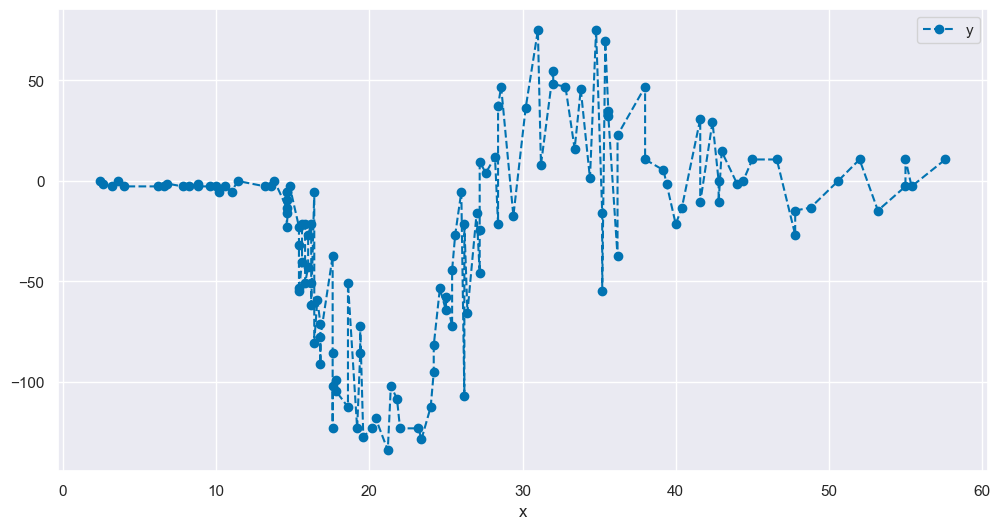

In [2]:
ax = df_raw.plot("x", "y", marker="o", ls="--", figsize=(12, 6))
plt.show()

#### Question 1
Transform the data to variables $(x, y, w)$ such that duplicated values are handled and ready to be fed to a weighted spline regression (cf TD Questions 5-6). 

In [3]:
df = df_raw.groupby("x", as_index= False).mean()
df["w"] = df_raw.groupby("x").size().values

x, y, w = df.values.T
df.head()

,x,y,w
0,2.4,0.0,1
1,2.6,-1.3,1
2,3.2,-2.7,1
3,3.6,0.0,1
4,4.0,-2.7,1


### Polynomial regression
Polynomial regression (fitting a best polynomial on the data) can be done using `np.polyfit` to obtain the coefficients and `polyval` to evaluate it.

#### Question 2
Perform (weighted) polynomial regression on the data and visualize the fitted curves for degrees 1, 3, 10 on the same plot. Try higher degree polynomial fits. Besides overfitting, why is this potentially a bad idea ?

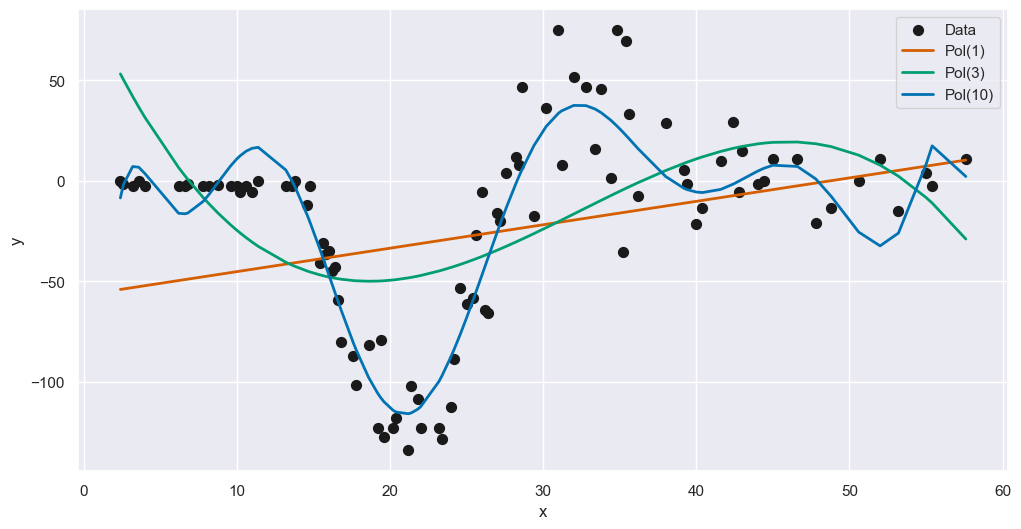

In [4]:
degrees = [1, 3, 10]

curves = []
for deg in degrees:
    coefs = np.polyfit(x, y, deg=deg, w=w)
    curves.append(np.polyval(coefs, x))

colors = ["r", "g", "b"]

plt.figure(figsize=(12, 6))
plt.scatter(x, y, marker="o", color="k", s=50, label="Data")
for deg, curve, c in zip(degrees, curves, colors):
    plt.plot(x, curve, label=f"Pol({deg})", color=c, lw=2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Cubic spline regression
#### Question 3
Complete the function `solve_splines_naive` that computes $g$ and $\gamma$ given the data. 

#### Question 4 
Knowing that $R + \alpha Q^\top Q$ is invertible, write an implementation of `solve_splines` that performs 0 matrix inversions.

In [5]:
def _construct_R_Q(x):
    """Function that constructs the matrices R and Q given the knots x_i."""
    n = len(x)
    h = np.diff(x)
    R = np.zeros((n-2, n-2))
    Q = np.zeros((n, n))
    
    # construct R
    indx = np.arange(n)
    # diag elements
    R[indx[:-2], indx[:-2]] = (h[1:] + h[:-1]) / 3
    # upper + lower diag elements
    R[indx[:-3], indx[1:-2]] = R[indx[1:-2], indx[:-3]] = h[1:-1] / 6
    
    # construct Q with the weird column indexing in mind in (n x n) matrix before filtering at the end
    Q[indx[1:-1], indx[1:-1]] = - 1 / h[1:] - 1 / h[:-1]
    Q[indx[2:], indx[1:-1]] = 1 / h[:-1]
    Q[indx[:-2], indx[1:-1]] = 1 / h[1:]
    
    # keep the n x n-2 matrix 
    Q = Q[:, 1:-1]

    return R, Q

def solve_splines_naive(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""
    R, Q = _construct_R_Q(x)
    W = np.diag(weights)

    #compute K 
    K = Q @ np.linalg.inv(R) @ Q.T
    g = np.linalg.inv(W + alpha * K) @ y
    gamma = np.linalg.inv(R) @ Q.T @ g
    return g, gamma


def solve_splines(x, y, weights, alpha=0.1):
    """Function that solves the problem and returns g and gamma."""
    
    return g, gamma

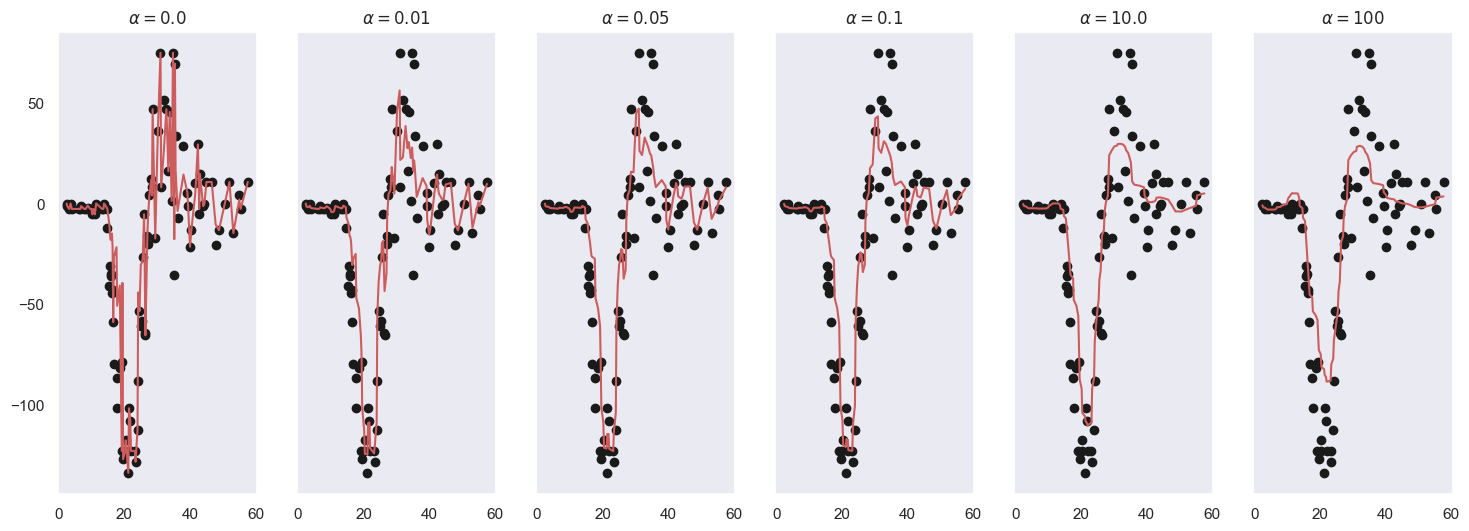

In [6]:
alphas = [0., 0.01, 0.05, 0.1, 10., 100]
f, axes = plt.subplots(1, 6, figsize=(18, 6), sharey=True)
for ax, alpha in zip(axes, alphas):
    g, gamma = solve_splines_naive(x, y, w, alpha=alpha)
    ax.scatter(x, y, color="k")
    ax.plot(x, g, color="indianred")
    ax.set_title(rf"$\alpha = {alpha}$")
    ax.grid()
plt.show()

#### Question 5
Implement a GCV function that returns the GCV score. Visualize the GCV score as a function of alpha.

In [7]:
def gcv(x, y, weights, alphas):
    """Compute GCV score for a grid of alphas"""
    n = len(y)
    W = np.diag(weights)
    R, Q = _construct_R_Q(x)
    K = Q.dot(np.linalg.inv(R)).dot(Q.T)
    vp = np.linalg.eigvals(K)
    gs = np.array([np.linalg.solve(W + alpha * K, W.dot(y)) for alpha in alphas])
    den = n * (1 - (1/(weights[None, :] + alphas[:, None] * vp[None, :])).mean(axis=1)) ** 2
    gcv_alpha = np.linalg.norm(gs - y[None, :], axis=1) ** 2/ den
    return gcv_alpha


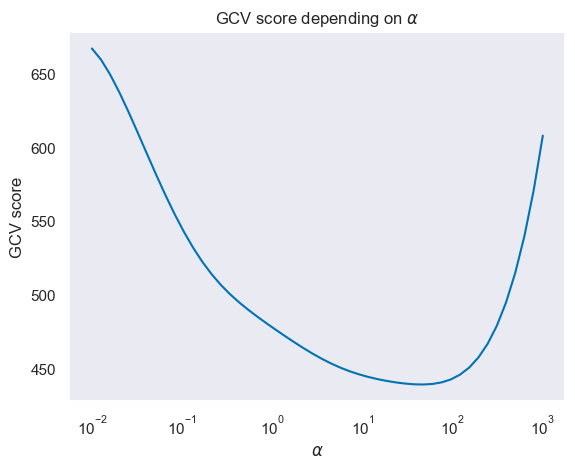

In [8]:
alphas = np.logspace(-2, 3, 50)
gcv_scores = gcv(x, y, w, alphas)
plt.figure()
plt.plot(alphas, gcv_scores)
plt.grid()
plt.xscale("log")
plt.xlabel(r"$\alpha$")
plt.ylabel("GCV score")
plt.title(r"GCV score depending on $\alpha$")
plt.show()

### Custom regressor and cross validation with scikit-learn
To evaluate the best polynomial fit using cross-validation, we write our own scikit-learn and use scikit-learn's GridSearchCV to perform cross-validation. 

#### Question 6
Fill the class below and find the best Polynomial fit:


In [9]:
from sklearn.base import RegressorMixin, BaseEstimator
from sklearn.model_selection import GridSearchCV, LeaveOneOut

class PolynomialFit(BaseEstimator, RegressorMixin):
    def __init__(self, degree=5):
        self.degree = degree
        
    def fit(self, x, y, weights=None):
        if weights is None:
            weights = np.ones_like(x)
        self.coefs = np.polyfit(x, y, deg=self.degree, w=weights)
        return self

    def predict(self, x):
        y_pred = np.polyval(self.coefs, x)
        return y_pred

params = {"degree": np.arange(16)}

cv = LeaveOneOut()
poly_cv = GridSearchCV(PolynomialFit(), params, cv=cv, scoring="neg_mean_squared_error")
poly_cv.fit(x, y)
poly_cv.best_estimator_

PolynomialFit(degree=8)

#### Question 7
See the content of `poly_cv.cv_results_` and plot the mean CV score as a function of the degree. 

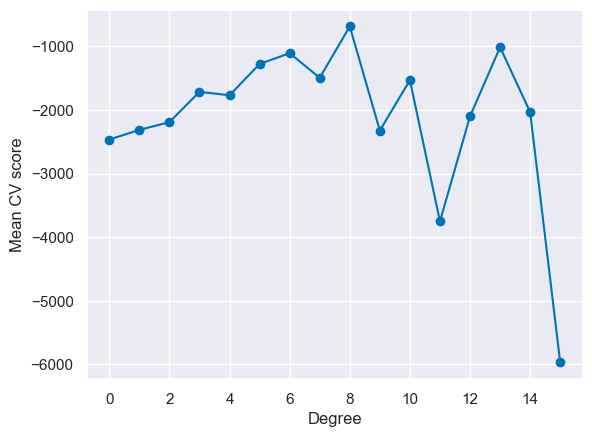

In [10]:
degrees = range(0, 16)
mean_scores = poly_cv.cv_results_['mean_test_score']

plt.plot(degrees, mean_scores, '-o')
plt.xlabel('Degree')
plt.ylabel('Mean CV score')
plt.show()

#### Question 8
Visualize the obtained best polynomial fit as well as the best cubic spline given by the GCV score minimizer.

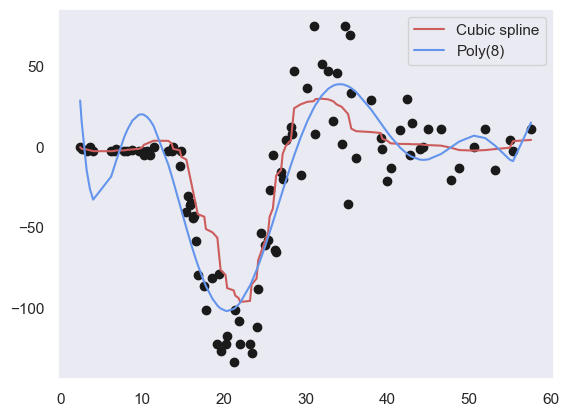

In [11]:
best_pol = poly_cv.best_estimator_.predict(x)
best_alpha = alphas[np.argmin(gcv_scores)]
g, _ = solve_splines_naive(x, y, w, best_alpha)

plt.figure()
plt.scatter(x, y, color="k")
plt.plot(x, g, color="indianred", label="Cubic spline")
plt.plot(x, best_pol, color="cornflowerblue", label=f"Poly({poly_cv.best_estimator_.degree})")
plt.grid()
plt.legend()
plt.show()

#### Question 9
Scikit-learn pipelines can be used to serialize several operations or models in one estimator. For ex:
```from sklearn.pipeline import Pipeline
pip = Pipeline([("Model_1_Name", Model1), ("Model_2_Name", Model2)])
pip.fit(X, y) ....
```
Using scikit-learn's `PolynomialFeatures` transformator, write a model that performs a polynomial.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

pip = Pipeline([
    ("poly", PolynomialFeatures(degree=8)),
    ("linear", LinearRegression())
])

x_reshaped = x.reshape(-1, 1)
y_reshaped = y.reshape(-1, 1)

pip.fit(x_reshaped, y_reshaped)
y_pred = pip.predict(x_reshaped)

#### Question 10
Perform cross validation on the degree of this model using scikit-learn.

In [14]:
from sklearn.model_selection import GridSearchCV

degrees = {
    'poly__degree': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

grid_search = GridSearchCV(pip, param_grid=degrees, cv=5)
grid_search.fit(x_reshaped, y_reshaped)

print("Best degree:", grid_search.best_params_['poly__degree'])
print("Best score:", grid_search.best_score_)

Best degree: 3
Best score: -185.16885867388254


Unfortunately, we don't find a polynomial of degree 8 as we'd have wanted.

#### Question 11
Find the analytical expression of the NCS given $g$ and $\gamma$ to evaluate it on any data point $x$. Visualize it on a grid of a few hundred regular points.

We consider $g$ defined on $[a, b]$. In order to perform a natural cubic spline, we divide this interval in $n$ intervals of the form $[t_i, t_{i+1}]$ for $i$ in ${0, 1, ..., n-1}$ with $t_0 = a$ and $t_n = b$.
We have the function $g$ which defines the cubic spline which means that it is a polynomial of degree 3 on each of those intervals. Since it is a natural cubic spline, hence $g \in \mathcal{C}^2[a,b]$. \
We also have the sequence $(\gamma_i)_{i}$ such that $\forall i \in {0,1, ..., n}$, $\gamma_i = g''(t_i)$. \
We will denote $g_i = g(t_i)$, $h_i = t_{i+1}-t_i$ and $S_i$, the function defined on $[t_i, t_{i+1}]$ which is equal to $g$ on this interval. Since $g$, $g'$ and $g''$ are continuous by definition, we have that $S_i(t_i) = S_{i-1}(t_i)$, $S'_i(t_i) = S'_{i-1}(t_i)$ and $S''_i(t_i) = S''_{i-1}(t_i)$. \
\
Let $i \in {0, 1, ..., n-1}$ and $t \in [t_i, t_{i+1}]$. We have :

\begin{equation}
S_i(t) = d_i(t-t_i)^3 + c_i(t-t_i)^2 + b_i(t-t_i) + a_i.
\end{equation}
We can compute a_i by evaluating $S_i$ at $t_i$ :
$\begin{align} a_i = S_i(t_i) = g_i \end{align}$
Then, let's consider $S_i$'s second derivative :
$\begin{align} S''_i(t) = 2c_i + 6d_i(t-t_i) \end{align}$ \
By definition, $S''_i(t_i) = \gamma_i$ and $S''_i(t_{i+1}) = \gamma_{i+1}$. Resolving this system of 2 equations and 2 variables, we get that $\forall i \in {0,1,...,n-1}$,
$\begin{align} c_i = \frac{\gamma_i}{2} \\ d_i = \frac{\gamma_{i+1}-\gamma_i}{6h_i} \end{align}$ \
To find the last coefficient, $b_i$, we evaluate $S_i$ at $t_{i+1}$ :
$\begin{equation} S_i(t_{i+1}) = g_{i+1} = \frac{\gamma_{i+1}+2\gamma_i}{6}h_i^2 + b_ih_i + g_i\end{equation}$
This gives : 
$\begin{equation} b_i = \frac{1}{h_i}(g_{i+1}-g_i) - \frac{h_i}{6}(\gamma_{i+1}+2\gamma_i) \end{equation}$
To conclude, $\forall i \in {0,1,...,n-1}$ we have :
\begin{equation}
\begin{cases}
a_i = g_i \\
b_i = \frac{1}{h_i}(g_{i+1}-g_i) - \frac{h_i}{6}(\gamma_{i+1}+2\gamma_i) \\
c_i = \frac{\gamma_i}{2} \\
d_i = \frac{\gamma_{i+1}-\gamma_i}{6h_i}
\end{cases}
\end{equation}
And since we know both g and gamma, we have all we need to evaluate the NCS on any $x$.

In [15]:
def ncs(x, g, gamma, t) :
    n = len(gamma)-1
    for i in range(n) :
        if t[i]<=x<=t[i+1] :
            h = t[i+1] - t[i]
            a = g[i]
            b = (g[i+1]-g[i])/h - h*(gamma[i+1]+2*gamma[i])
            c = gamma[i]/2
            d = (gamma[i+1]-gamma[i])/(6*h)
            val = d*(x-t[i])**3 + c*(x-t[i])**2 + b*(x-t[i]) + a
            return val

We found $g$ with the previous questions, but we have no idea how to run the code since we don't have access to $\gamma$.